In [1]:
from trading_agent.trading_simulator import TradingSimulator, TradingSimulatorConfig
from trading_agent.random_trading_agent import RandomTradingAgent
from trading_agent.explainable_option_trading_agent import ExplainableOptionTradingAgent
from trading_agent.base_trading_agent import BaseTradingAgent
from trading_agent.utils.order_hist_visualizer import plot_order_history
import pandas as pd
from collections import defaultdict
import json
from pprint import pprint
from tqdm import tqdm
import numpy as np

In [2]:
TEST_RATIO = 0.2

REWARD_FACTOR = 0.995
LOSS_FACTOR = 1.005
INIT_BALANCE = 100

RANDOM_TESTING_TIMES = 3000
EXPLAINABLE_TESTING_TIMES = 3000

# Create dataset

In [3]:
sentiment_df = pd.read_csv("../data/tesla_tweets_with_sentiment_all.csv")
sentiment_df["Date"] = pd.to_datetime(sentiment_df["Date"]).dt.date

In [4]:
# Compute split date
dates = sentiment_df["Date"].unique()[::-1]
split_index = int(len(dates) * (1 - TEST_RATIO))
split_date = dates[split_index]
print(f"Split date: {split_date}")

Split date: 2022-07-19


In [5]:
def recalibrate_sentiment(sentiment_df, max_date: str = None):
    """
    Due to very few negative tweets, we need to recalibrate the sentiment scores
    Which this function will label low confidence 'positive' sentiments as 'neutral'
    and the threshold for 'positive' sentiment is set by use the minimum score that make mean of
    negative sentiment and positive sentiment are most close
    """
    if max_date is None:
        max_date = sentiment_df["Date"].max()

    start_threshold, end_threshold = 0.0, 1.0
    minimum_diff = float("inf")
    minimum_threshold = 0.0
    minimum_range = 0.1
    while end_threshold - start_threshold > minimum_range:
        # Calculate the mean negative and positive ratios
        threshold = (start_threshold + end_threshold) / 2
        # Recalibrate the sentiment labels
        # temp_df = sentiment_df[sentiment_df['Date'] <= max_date].copy()
        temp_df = sentiment_df[pd.to_datetime(sentiment_df["Date"]) <= pd.to_datetime(max_date)].copy()
        temp_df.loc[temp_df["sentiment_label"] == "positive", "sentiment_label"] = temp_df.loc[
            temp_df["sentiment_label"] == "positive", "sentiment_score"
        ].apply(lambda x: "neutral" if x < threshold else "positive")
        # Compute the ratio for each sentiment label
        temp_df = (
            temp_df.groupby("Date")
            .agg(
                count=("sentiment_label", "size"),
                negative_count=("sentiment_label", lambda x: (x == "negative").sum()),
                positive_count=("sentiment_label", lambda x: (x == "positive").sum()),
                neutral_count=("sentiment_label", lambda x: (x == "neutral").sum()),
            )
            .reset_index()
        )
        temp_df["negative_ratio"] = temp_df["negative_count"] / temp_df["count"]
        temp_df["positive_ratio"] = temp_df["positive_count"] / temp_df["count"]
        temp_df["neutral_ratio"] = temp_df["neutral_count"] / temp_df["count"]

        mean_negative_ratio = temp_df["negative_ratio"].mean()
        mean_positive_ratio = temp_df["positive_ratio"].mean()

        if minimum_diff > abs(mean_negative_ratio - mean_positive_ratio):
            minimum_diff = abs(mean_negative_ratio - mean_positive_ratio)
            minimum_threshold = threshold

        if mean_positive_ratio > mean_negative_ratio:
            start_threshold = threshold
        else:
            end_threshold = threshold
    print(f"Minimum threshold: {minimum_threshold}")

    # Recalibrate the sentiment labels based on the minimum threshold
    sentiment_df.loc[sentiment_df["sentiment_label"] == "positive", "sentiment_label"] = sentiment_df.loc[
        sentiment_df["sentiment_label"] == "positive", "sentiment_score"
    ].apply(lambda x: "neutral" if x < minimum_threshold else "positive")

    # Compute weight for each sentiment label
    positive_count = sentiment_df[
        (sentiment_df["sentiment_label"] == "positive") & (sentiment_df["Date"] <= max_date)
    ].shape[0]
    negative_count = sentiment_df[
        (sentiment_df["sentiment_label"] == "negative") & (sentiment_df["Date"] <= max_date)
    ].shape[0]
    neutral_count = sentiment_df[
        (sentiment_df["sentiment_label"] == "neutral") & (sentiment_df["Date"] <= max_date)
    ].shape[0]
    total_count = positive_count + negative_count + neutral_count

    sentiment_weights = {
        "positive": 1 / (positive_count / total_count),
        "negative": 1 / (negative_count / total_count),
        "neutral": 1 / (neutral_count / total_count),
    }

    sentiment_df["sentiment_weight"] = sentiment_df["sentiment_label"].apply(lambda x: sentiment_weights.get(x, 0))

    return sentiment_df, sentiment_weights


sentiment_df, sentiment_weights = recalibrate_sentiment(sentiment_df, max_date=split_date)

Minimum threshold: 0.875


In [6]:
# Count the number of tweets for each date
temp_df = (
    sentiment_df.groupby("Date")
    .agg(
        count=("sentiment_label", "size"),
        negative_count=("sentiment_label", lambda x: (x == "negative").sum()),
        positive_count=("sentiment_label", lambda x: (x == "positive").sum()),
        neutral_count=("sentiment_label", lambda x: (x == "neutral").sum()),
    )
    .reset_index()
)

# Calculate the ratio for each sentiment label
temp_df["negative_sum"] = temp_df["negative_count"] * sentiment_weights["negative"]
temp_df["positive_sum"] = temp_df["positive_count"] * sentiment_weights["positive"]
temp_df["neutral_sum"] = temp_df["neutral_count"] * sentiment_weights["neutral"]

temp_df["major"] = temp_df[["negative_sum", "positive_sum", "neutral_sum"]].idxmax(axis=1)
temp_df["major"] = temp_df["major"].apply(lambda x: x.split("_")[0])

In [7]:
sentiment_df = temp_df[["Date", "major"]]
sentiment_df.columns = ["Date", "sentiment_label"]

In [8]:
p_et = dict()

sentiment_count = temp_df.groupby("major").agg(
    count=("major", "size"),
)
total_count = sentiment_count["count"].sum()

for sentiment in sentiment_count.index:
    p_et[sentiment] = float(sentiment_count.loc[sentiment].iloc[0] / total_count)

with open("./p_et.json", "w") as f:
    json.dump(p_et, f, indent=4)

In [9]:
# Load price data
price_df = pd.read_csv("../data/date_with_x_t.csv")
price_df["Date"] = pd.to_datetime(price_df["Date"]).dt.date
price_df["is_train"] = price_df["Date"] < split_date

# Merge price and sentiment dataframes and mark train/test split
price_and_sentiment_df = pd.merge(price_df, sentiment_df, on="Date", how="inner")

In [10]:
p_xt = dict()

price_up_amount = price_and_sentiment_df[price_and_sentiment_df["is_train"]]["x_t"].sum()
price_down_amount = len(price_and_sentiment_df[price_and_sentiment_df["is_train"]]) - price_up_amount
total_amount = len(price_and_sentiment_df[price_and_sentiment_df["is_train"]])

p_xt["up"] = float(price_up_amount / total_amount)
p_xt["down"] = float(price_down_amount / total_amount)

with open("./p_xt.json", "w") as f:
    json.dump(p_xt, f, indent=4)
pprint(p_xt)

{'down': 0.48, 'up': 0.52}


In [11]:
p_et_given_xt = defaultdict(dict)

for sentiment in p_et.keys():
    for price_state in p_xt.keys():
        # Find prob of sentiment given price state
        current_xt_and_et = price_and_sentiment_df[
            (price_and_sentiment_df["is_train"])
            & (price_and_sentiment_df["sentiment_label"] == sentiment)
            & (price_and_sentiment_df["x_t"] == (1 if price_state == "up" else 0))
        ]
        total_amount = len(price_and_sentiment_df[price_and_sentiment_df["is_train"]])

        p_et_and_xt = len(current_xt_and_et) / total_amount
        p_et_given_xt[sentiment][price_state] = float(p_et_and_xt / p_xt[price_state])
p_et_given_xt = dict(p_et_given_xt)

with open("./p_et_given_xt.json", "w") as f:
    json.dump(p_et_given_xt, f, indent=4)
pprint(p_et_given_xt)

{'negative': {'down': 0.5833333333333334, 'up': 0.3269230769230769},
 'neutral': {'down': 0.2604166666666667, 'up': 0.24038461538461536},
 'positive': {'down': 0.15625, 'up': 0.4326923076923077}}


In [12]:
p_xt_given_xprevt = defaultdict(dict)

# Find prob of price state given previous price state
temp_df = price_and_sentiment_df.copy()
temp_df["x_t-1"] = temp_df["x_t"].shift(1).astype("Int64")
temp_df = temp_df[1:]


for price_state in p_xt.keys():
    for prev_price_state in p_xt.keys():
        # Find prob of price state given previous price state
        current_xt_and_xprevt = temp_df[
            (temp_df["is_train"])
            & (temp_df["x_t"] == (1 if price_state == "up" else 0))
            & (temp_df["x_t-1"] == (1 if prev_price_state == "up" else 0))
        ]
        total_amount = len(temp_df[temp_df["is_train"]])

        p_xt_and_xprevt = len(current_xt_and_xprevt) / total_amount
        p_xt_given_xprevt[price_state][prev_price_state] = float(p_xt_and_xprevt / p_xt[prev_price_state])

p_xt_given_xprevt = dict(p_xt_given_xprevt)
with open("./p_xt_given_xprevt.json", "w") as f:
    json.dump(p_xt_given_xprevt, f, indent=4)

pprint(p_xt_given_xprevt)

{'down': {'down': 0.5025125628140703, 'up': 0.45419404715887124},
 'up': {'down': 0.49204355108877723, 'up': 0.5508310784692695}}


In [13]:
# Create a new dataframe with the merged data
price_tsla_1d = pd.read_csv("../data/price_1d_tsla.csv")
price_tsla_1d["Date"] = pd.to_datetime(price_tsla_1d["Date"]).dt.date

pd.merge(price_tsla_1d, price_and_sentiment_df, on="Date", how="right").to_csv("./tesing.csv")

# Run testing

In [ ]:
split_date = "2022-07-19"

In [ ]:
def test_multiple_times(
    trading_agent: BaseTradingAgent, trading_sim: TradingSimulator, num_times: int = 10, tqdm_disable: bool = False
):
    """
    Test the trading agent multiple times and return the average profit
    """
    best_result = None
    worse_result = None
    run_history = []

    # Run the simulation multiple times
    for _ in tqdm(range(num_times), disable=tqdm_disable):
        result = trading_sim.run_simulation(trading_agent)
        # Store the balance history
        run_history.append(result)

    balance_history = np.array([result.balance for result in run_history])

    return {
        "best_result": best_result,
        "worse_result": worse_result,
        "best_profit": round((best_result.balance - INIT_BALANCE) / INIT_BALANCE * 100, 2),
        "worse_profit": round((worse_result.balance - INIT_BALANCE) / INIT_BALANCE * 100, 2),
        "average_profit": round((balance_history.sum() / len(balance_history) - INIT_BALANCE) / INIT_BALANCE * 100, 2),
        "std_dev": round((balance_history.std()), 2),
    }

In [15]:
trading_sim_config = TradingSimulatorConfig(
    price_dataframe_path="./tesing.csv",
    buy_at="Close",
    sell_at="Open",
    trade_type="option",
    reward_factor=REWARD_FACTOR,
    loss_factor=LOSS_FACTOR,
    initial_balance=INIT_BALANCE,
)
trading_sim = TradingSimulator(trading_sim_config)

## Random trading agent

In [16]:
best_result, worse_result, best_profit, worse_profit, average_profit, std_dev = test_multiple_times(
    RandomTradingAgent(), trading_sim, num_times=RANDOM_TESTING_TIMES
).values()

print("Best result profit    :", best_profit, "%")
print("Worse result profit   :", worse_profit, "%")
print()
print("Average profit        :", average_profit, "%")
print("Standard deviation    :", std_dev, "%")

100%|██████████| 3000/3000 [00:17<00:00, 175.60it/s]

Best result profit    : 51.75 %
Worse result profit   : -72.25 %

Average profit        : -1.55 %
Standard deviation    : 16.07 %


## Explainable trading agent

### Viterbi algo

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import time

Testing evidence num:   0%|          | 0/50 [00:00<?, ?evidence_num/s]/var/folders/5g/160h3py942nb4pbbgy0dhtz40000gn/T/ipykernel_47820/1079279999.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compare_df = pd.concat([compare_df, pd.DataFrame([row])], ignore_index=True)
Testing evidence num: 100%|██████████| 50/50 [07:55<00:00,  9.50s/evidence_num]


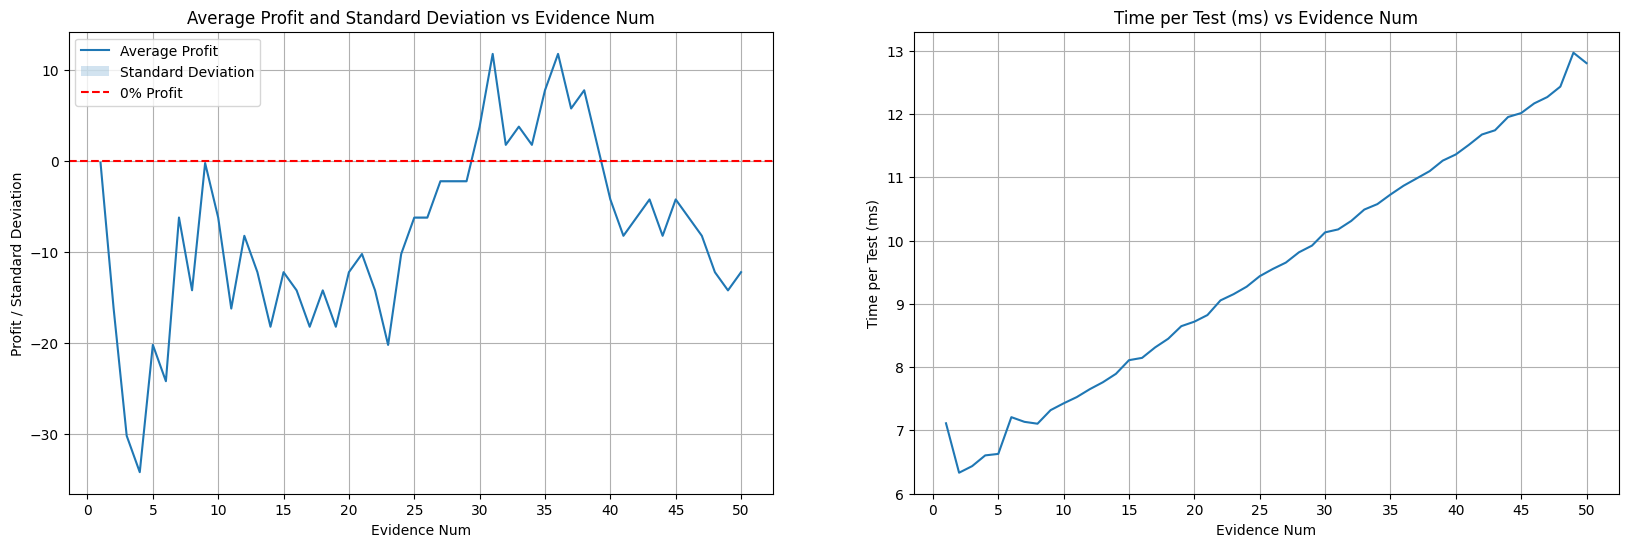

In [18]:
compare_df = pd.DataFrame([], columns=["evidence_num", "average_profit", "std_dev", "time per test"])

for evidence_num in tqdm(range(1, 51), desc="Testing evidence num", unit="evidence_num"):
    explainable_option_agent = ExplainableOptionTradingAgent(
        p_et_path="./p_et.json",
        p_xt_path="./p_xt.json",
        p_xt_given_xprevt_path="./p_xt_given_xprevt.json",
        p_et_given_xt_path="./p_et_given_xt.json",
        inference_method="viterbi",
        viterbi_evidence_num=evidence_num,
    )

    start_time = time.time()
    best_result, worse_result, best_profit, worse_profit, average_profit, std_dev = test_multiple_times(
        explainable_option_agent, trading_sim, num_times=1000, tqdm_disable=True
    ).values()
    end_time = time.time()
    time_per_test = end_time - start_time

    row = {
        "evidence_num": evidence_num,
        "average_profit": average_profit,
        "std_dev": std_dev,
        "time per test": time_per_test,
    }
    compare_df = pd.concat([compare_df, pd.DataFrame([row])], ignore_index=True)

plt.figure(figsize=(20, 6))

# Plot average profit and standard deviation
plt.subplot(1, 2, 1)
sns.lineplot(data=compare_df, x="evidence_num", y="average_profit", label="Average Profit")
plt.fill_between(
    np.array(compare_df["evidence_num"], dtype=int),
    np.array(compare_df["average_profit"] - compare_df["std_dev"], dtype=float),
    np.array(compare_df["average_profit"] + compare_df["std_dev"], dtype=float),
    alpha=0.2,
    label="Standard Deviation",
)
plt.axhline(0, color="red", linestyle="--", label="0% Profit")
plt.xticks(np.arange(0, 51, 5))
plt.title("Average Profit and Standard Deviation vs Evidence Num")
plt.xlabel("Evidence Num")
plt.ylabel("Profit / Standard Deviation")
plt.legend()
plt.grid()

# Plot time per test vs evidence num
plt.subplot(1, 2, 2)
sns.lineplot(data=compare_df, x="evidence_num", y="time per test")
plt.xticks(np.arange(0, 51, 5))
plt.title("Time per Test (ms) vs Evidence Num")
plt.xlabel("Evidence Num")
plt.ylabel("Time per Test (ms)")
plt.grid()

plt.show()

100%|██████████| 3000/3000 [00:31<00:00, 95.03it/s]


Best result profit    : 11.75 %
Worse result profit   : 7.75 %
Average profit        : 11.74 %



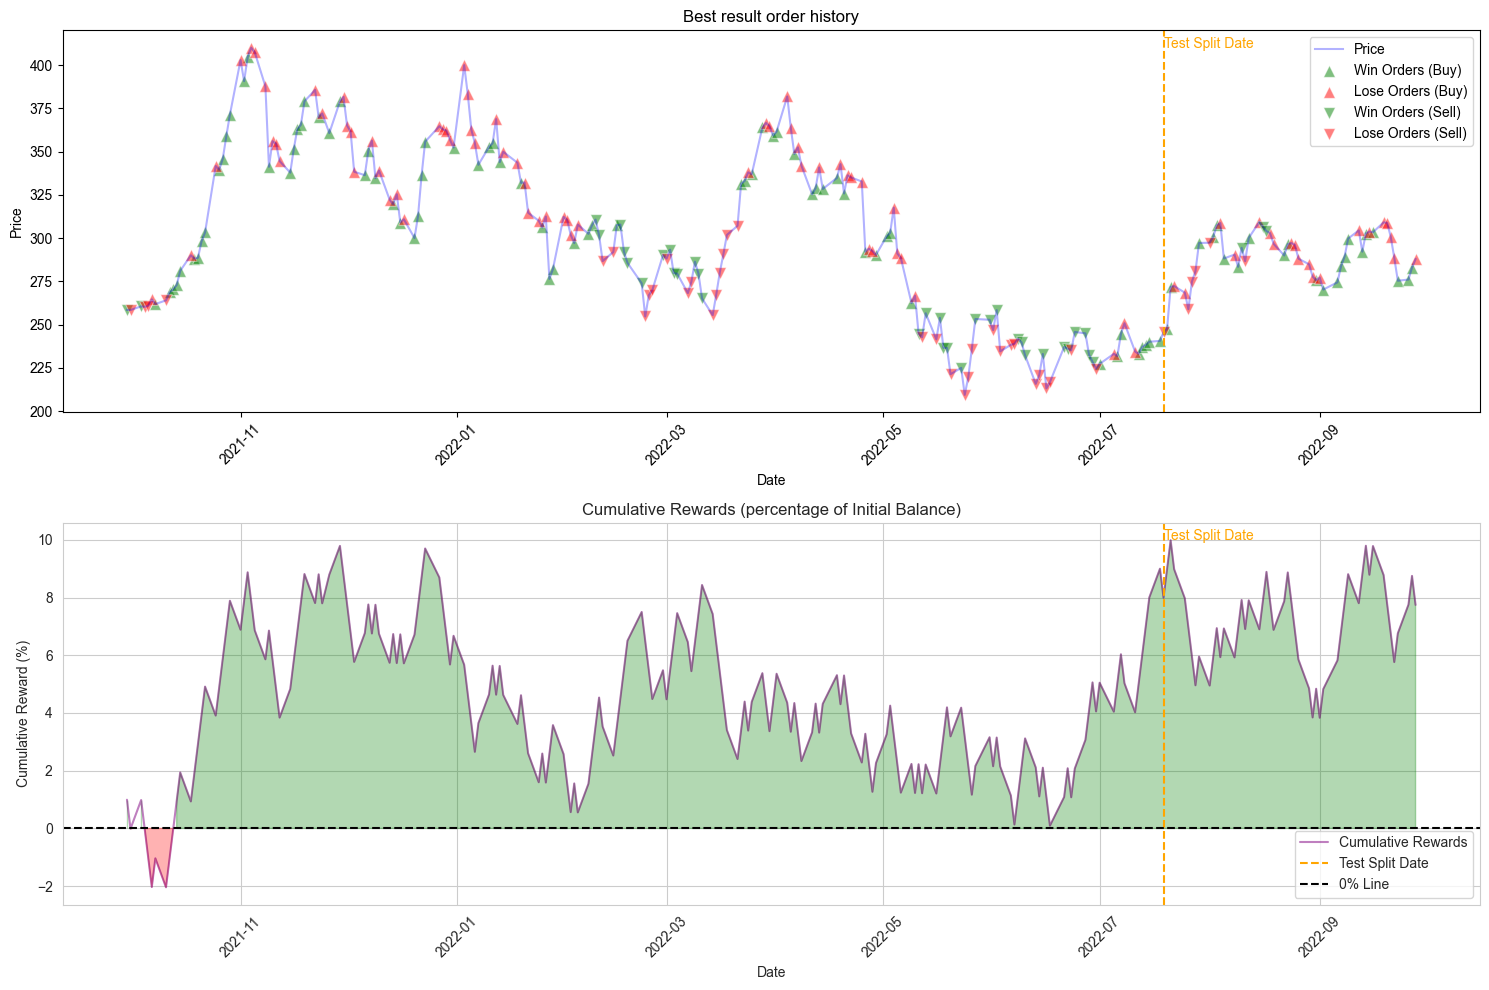

In [19]:
result = test_multiple_times(
    ExplainableOptionTradingAgent(
        p_et_path="./p_et.json",
        p_xt_path="./p_xt.json",
        p_xt_given_xprevt_path="./p_xt_given_xprevt.json",
        p_et_given_xt_path="./p_et_given_xt.json",
        inference_method="viterbi",
        viterbi_evidence_num=31,
    ),
    trading_sim,
    num_times=EXPLAINABLE_TESTING_TIMES,
)

print("Best result profit    :", result["best_profit"], "%")
print("Worse result profit   :", result["worse_profit"], "%")
print("Average profit        :", result["average_profit"], "%")
print()

plot_order_history(
    result["worse_result"].order_history,
    initial_balance=INIT_BALANCE,
    title="Best result order history",
    test_split_date=split_date,
)

Testing evidence num:   0%|          | 0/50 [00:00<?, ?evidence_num/s]/var/folders/5g/160h3py942nb4pbbgy0dhtz40000gn/T/ipykernel_47820/3104043116.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  compare_df = pd.concat([compare_df, pd.DataFrame([row])], ignore_index=True)
Testing evidence num: 100%|██████████| 50/50 [08:25<00:00, 10.11s/evidence_num]


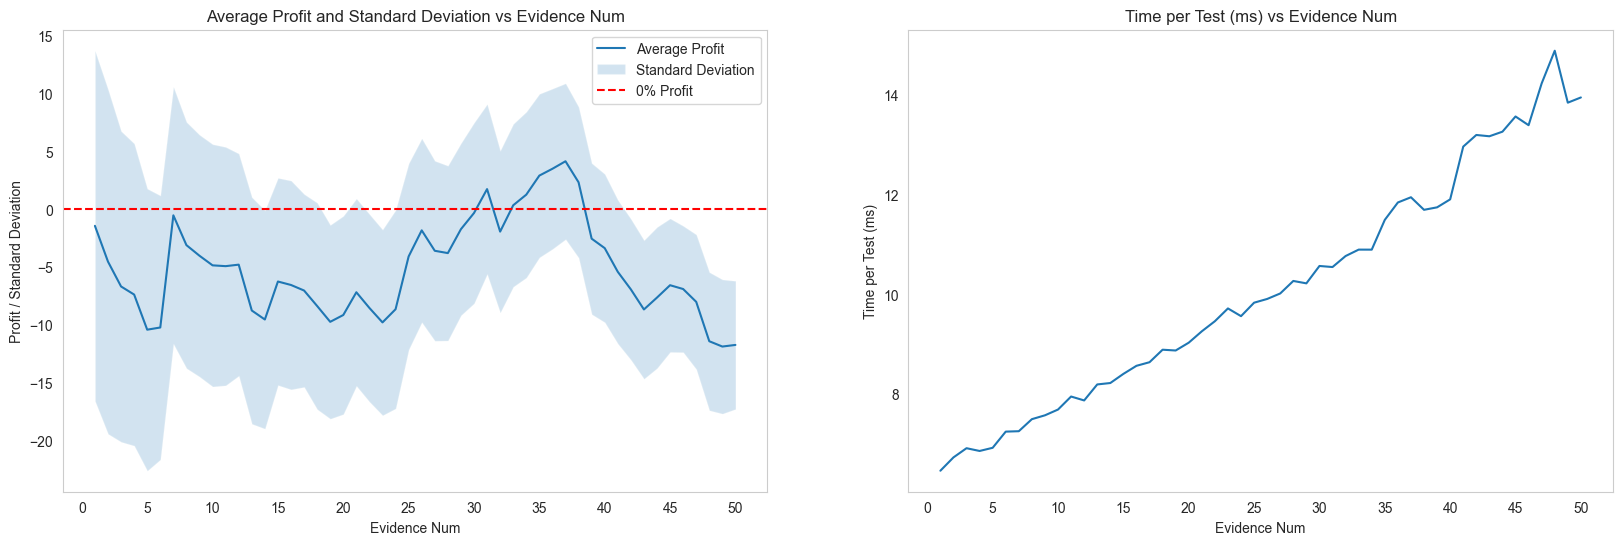

In [20]:
compare_df = pd.DataFrame([], columns=["evidence_num", "average_profit", "std_dev", "time per test"])

for evidence_num in tqdm(range(1, 51), desc="Testing evidence num", unit="evidence_num"):
    explainable_option_agent = ExplainableOptionTradingAgent(
        p_et_path="./p_et.json",
        p_xt_path="./p_xt.json",
        p_xt_given_xprevt_path="./p_xt_given_xprevt.json",
        p_et_given_xt_path="./p_et_given_xt.json",
        inference_method="viterbi",
        viterbi_evidence_num=evidence_num,
        picking_action_method="random_by_prob",
    )

    start_time = time.time()
    best_result, worse_result, best_profit, worse_profit, average_profit, std_dev = test_multiple_times(
        explainable_option_agent, trading_sim, num_times=1000, tqdm_disable=True
    ).values()
    end_time = time.time()
    time_per_test = end_time - start_time

    row = {
        "evidence_num": evidence_num,
        "average_profit": average_profit,
        "std_dev": std_dev,
        "time per test": time_per_test,
    }
    compare_df = pd.concat([compare_df, pd.DataFrame([row])], ignore_index=True)

plt.figure(figsize=(20, 6))

# Plot average profit and standard deviation
plt.subplot(1, 2, 1)
sns.lineplot(data=compare_df, x="evidence_num", y="average_profit", label="Average Profit")
plt.fill_between(
    np.array(compare_df["evidence_num"], dtype=int),
    np.array(compare_df["average_profit"] - compare_df["std_dev"], dtype=float),
    np.array(compare_df["average_profit"] + compare_df["std_dev"], dtype=float),
    alpha=0.2,
    label="Standard Deviation",
)
plt.axhline(0, color="red", linestyle="--", label="0% Profit")
plt.xticks(np.arange(0, 51, 5))
plt.title("Average Profit and Standard Deviation vs Evidence Num")
plt.xlabel("Evidence Num")
plt.ylabel("Profit / Standard Deviation")
plt.legend()
plt.grid()

# Plot time per test vs evidence num
plt.subplot(1, 2, 2)
sns.lineplot(data=compare_df, x="evidence_num", y="time per test")
plt.xticks(np.arange(0, 51, 5))
plt.title("Time per Test (ms) vs Evidence Num")
plt.xlabel("Evidence Num")
plt.ylabel("Time per Test (ms)")
plt.grid()

plt.show()

100%|██████████| 3000/3000 [00:35<00:00, 83.80it/s]


Best result profit    : 5.75 %
Worse result profit   : 1.75 %
Average profit        : 5.74 %



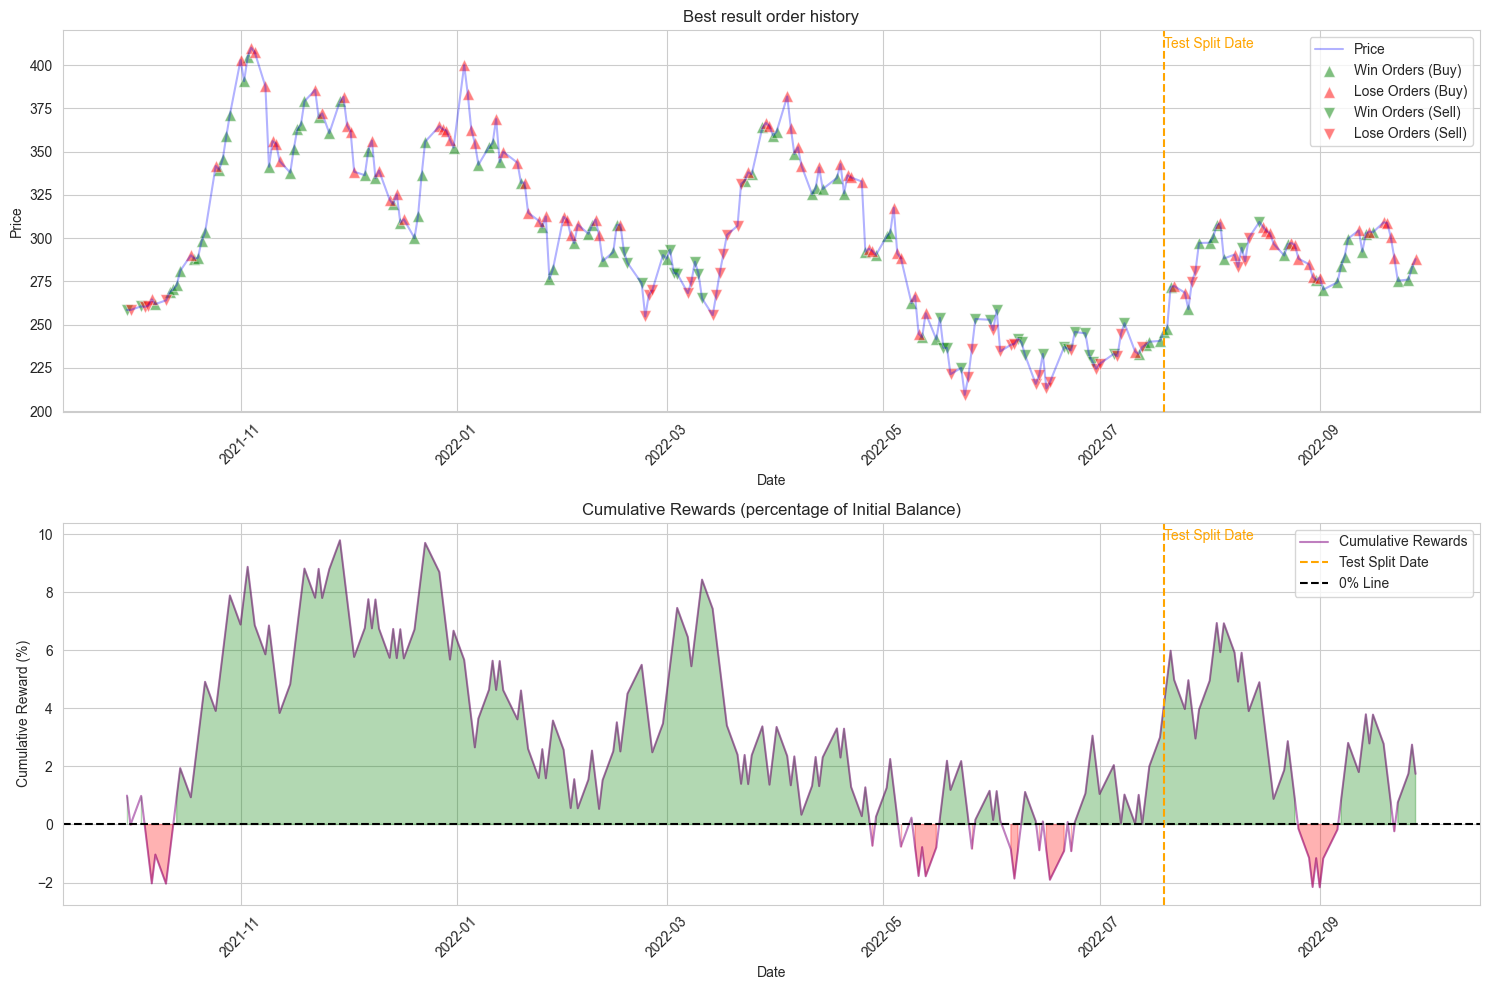

In [21]:
result = test_multiple_times(
    ExplainableOptionTradingAgent(
        p_et_path="./p_et.json",
        p_xt_path="./p_xt.json",
        p_xt_given_xprevt_path="./p_xt_given_xprevt.json",
        p_et_given_xt_path="./p_et_given_xt.json",
        inference_method="viterbi",
        viterbi_evidence_num=37,
    ),
    trading_sim,
    num_times=EXPLAINABLE_TESTING_TIMES,
)

print("Best result profit    :", result["best_profit"], "%")
print("Worse result profit   :", result["worse_profit"], "%")
print("Average profit        :", result["average_profit"], "%")
print()

plot_order_history(
    result["worse_result"].order_history,
    initial_balance=INIT_BALANCE,
    title="Best result order history",
    test_split_date=split_date,
)